# Imports

Import needed libraries

In [ ]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import numpy as np
import random
from scipy import signal
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Mount to Google Drive (optional)

In [ ]:
# Mounting your Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"

# Defined functions for easier work with data

## Functions to load datasets

In [ ]:
# RadioML2016.10a/10b or MIGOU MOD

def load_dataset(dataset):
    """
    Load and preprocess the dataset for use in machine learning models.

    Args:
        dataset (dict): A dictionary with keys as tuples (modulation, SNR) and values as I/Q data arrays.

    Returns:
        tuple: A tuple containing:
            - snrs (list): Sorted list of unique SNR values.
            - X (numpy.ndarray): Stacked array of I/Q data shaped as [num_of_samples, 128, 2].
            - modulations (list): Sorted list of unique modulation types.
            - one_hot_encode (numpy.ndarray): One-hot encoded labels for modulations.
            - lbl_SNR (numpy.ndarray): SNR labels for each data sample.
    """
    # Extract unique SNRs and modulations
    snrs = sorted(set(key[1] for key in dataset.keys()))
    modulations = sorted(set(key[0] for key in dataset.keys()))

    # Initialize lists for data and labels
    X, lbl = [], []

    # Populate the lists with data entries and corresponding labels
    for mod in modulations:
        for snr in snrs:
            X.append(dataset[(mod, snr)])
            lbl.extend([(mod, snr)] * dataset[(mod, snr)].shape[0])

    # Convert list to a single numpy array and reshape
    X = np.vstack(X)
    lbl = np.array(lbl)

    # Transpose dimensions of X to match [num_of_samples, 128, 2]
    X = np.transpose(X, (0, 2, 1))

    # Generate one-hot labels for modulations
    mod_indices = {mod: idx for idx, mod in enumerate(modulations)}
    one_hot_encode = np.eye(len(modulations))[np.vectorize(mod_indices.get)(lbl[:, 0])]

    # Prepare SNR labels for each sample
    repeat_n = X.shape[0] / (len(modulations) * len(snrs))
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), len(modulations))

    return snrs, X, modulations, one_hot_encode, lbl_SNR


In [ ]:
# RML2016.10b / just for the way it is saved in my GoogleDrive

def load_RMLb_dataset(X, lbl):
    """
    Load and preprocess the RML2016.10b dataset.

    Args:
        X (numpy.ndarray): Array of I/Q data.
        lbl (numpy.ndarray): Labels containing modulations and SNR values.

    Returns:
        tuple: A tuple containing:
            - snrs (list): Sorted list of unique SNR values.
            - X (numpy.ndarray): Input I/Q data.
            - mods (numpy.ndarray): Array of unique modulation types.
            - one_hot_encode (numpy.ndarray): One-hot encoded labels for modulations.
            - lbl_SNR (numpy.ndarray): SNR labels for each data sample.
    """
    mods = np.unique(lbl[:,0])
    snrs = np.unique(lbl[:,1]).astype(int)
    snrs.sort()

    # Map modulations to integers for one-hot encoding
    mod_to_index = {mod: index for index, mod in enumerate(mods)}
    mod_indices = np.vectorize(mod_to_index.get)(lbl[:, 0])
    one_hot_encode = to_categorical(mod_indices, num_classes=len(mods))

    # Prepare SNR labels for each sample
    num_samples_per_mod_snr = X.shape[0] // (len(mods) * len(snrs))
    lbl_SNR = np.repeat(snrs, num_samples_per_mod_snr * len(mods))

    return snrs.tolist(), X, mods, one_hot_encode, lbl_SNR


## Functions to handle the datasets

In [ ]:
import numpy as np

def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):
    """
    Efficiently splits the dataset into training, validation, and testing sets based on provided ratios.

    Args:
        X (numpy.ndarray): The input features.
        one_hot (numpy.ndarray): The one-hot encoded target labels.
        train_split (float, optional): Fraction of the data to be used for training. Defaults to 0.7.
        valid_split (float, optional): Fraction of the data to be used for validation. Defaults to 0.15.
        test_split (float, optional): Fraction of the data to be used for testing. Defaults to 0.15.

    Returns:
        tuple: Tuple containing indices and data for train, validation, and test sets.
    """
    assert np.isclose(train_split + valid_split + test_split, 1), "The splits must sum to 1!"

    # Set random seed for reproducibility
    np.random.seed(42)

    # Shuffle indices
    indices = np.random.permutation(X.shape[0])

    # Calculate split indices
    n_train = int(X.shape[0] * train_split)
    n_valid = int(X.shape[0] * valid_split)

    # Split the indices for train, validation, and test
    train_idx, valid_idx, test_idx = indices[:n_train], indices[n_train:n_train + n_valid], indices[n_train + n_valid:]

    # Split the data
    X_train, X_valid, X_test = X[train_idx], X[valid_idx], X[test_idx]
    Y_train, Y_valid, Y_test = one_hot[train_idx], one_hot[valid_idx], one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test


In [ ]:
def normalize_data(X_train, X_valid, X_test):
    """
    Normalizes the training, validation, and test datasets using mean and standard deviation
    computed from the training data.

    Args:
        X_train, X_valid, X_test (numpy.ndarray): Data arrays to be normalized, assumed to be 3-dimensional.

    Returns:
        tuple: Normalized training, validation, and test data arrays.
    """
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train -= mean
    X_train /= std

    X_valid -= mean
    X_valid /= std
    X_test -= mean
    X_test /= std

    return X_train, X_valid, X_test


In [ ]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

## Functions for plotting

In [ ]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel
    """

    cm = confusion_matrix(validations, predictions)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save == True:
        plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')
    plt.show(block=False)


In [ ]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, None, save)

In [ ]:
def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):
    """
    Plot confusion matrices of chosen SNRs

    in_snr:   must be list of SNRs
    X_test:   X_test data
    """
    for snr in in_snr:
        matrix_snr = snr
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)

In [ ]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):
    x = np.arange(len(mods))  # Label locations
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots()
    # Adjust the positions of bars to ensure they don't overlap and are centered on ticks
    bar1 = ax.bar(x - width, np.count_nonzero(Y_train == 1, axis=0), width, label="Train")
    bar2 = ax.bar(x, np.count_nonzero(Y_valid == 1, axis=0), width, label="Valid")
    bar3 = ax.bar(x + width, np.count_nonzero(Y_test == 1, axis=0), width, label="Test")

    # Labels and title
    ax.set_ylabel('Counts')
    ax.set_title('Label Distribution in Train, Valid, Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend()

    # Optionally add text labels to each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bar1)
    autolabel(bar2)
    autolabel(bar3)
    fig.tight_layout()  # Adjust subplots to give some padding

    return plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Assume these are defined somewhere in your notebook or script
global test_idx, lbl_SNR, X_test, Y_test, model

def SNR_accuracy(in_snr, name):
    """
    Computes and plots accuracies of chosen SNRs individually, assuming global variables for test indices,
    SNR labels, test features, test labels, and the model.

    Args:
        in_snr (list): List of SNRs to evaluate.
        name (str): Label name for the plot.

    Returns:
        numpy.ndarray: Array of accuracies for each SNR.
    """
    test_snr = lbl_SNR[test_idx]  # Extract test SNRs using indices
    acc = []

    for snr in in_snr:
        idx_acc_snr = np.where(test_snr == int(snr))[0]  # Get indices where SNR matches

        if idx_acc_snr.size > 0:
            acc_X_test = X_test[idx_acc_snr]
            acc_Y_test = Y_test[idx_acc_snr]
            print(f'\nSNR {snr} dB:')
            accuracy_snr = model.evaluate(acc_X_test, acc_Y_test, batch_size=32, verbose=2)
            acc.append(accuracy_snr)
        else:
            acc.append([0, 0])  # Handle case with no samples at this SNR

    acc = np.array(acc)
    # Plotting
    fig, ax = plt.subplots()
    ax.plot(in_snr, acc[:, 1] * 100, 'steelblue', marker='.', markersize=15, label=name, linestyle='-')
    ax.legend(loc='best', prop={'size': 15})
    ax.set_xticks(np.arange(min(in_snr), max(in_snr) + 1, 2))
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_yticks(np.arange(0, 101, 2), minor=True)
    ax.grid(True, which='both', linestyle='-', color='lightgray')
    ax.set_xlim(min(in_snr), max(in_snr))
    ax.set_ylim(0, 100)
    ax.set_title("Classification Accuracy by SNR", fontsize=20)
    ax.set_xlabel('SNR (dB)', fontsize=20)
    ax.set_ylabel('Accuracy (%)', fontsize=20)
    plt.show()

    return acc[:, 1]


## Functions for visualization of layers

In [ ]:
def layer_overview(model):

    """
    Offers overview of the model's layers and theirs outputs

    model: specify trained model you want to have overview of
    """

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    return layer_names, layer_outputs

def model_visualization(nth_layer, nth_test_idx, mods, model,
                        plot_sample = False, plot_activations = True,
                        plot_feature_maps = True):

    """
    The function provised overview of activation of specific layer and its
    feature maps.

    nth_layer: enter number which corresponds with the position of wanted layer
    nth_test_idx: enter number pointing at the test indexes from earlier
    mods: provide variable which holds listed modulations
    model: specify which trained model to load
    plot_sample = False: set to true to plot sample data
    plot_activations = True: plots activation of chosen layer
    plot_feature_maps = True: plots feature map of chosen layer
    """

    # Sample data for visualization
    test_sample = X_test[nth_test_idx,:,:] # shape [128,2]
    test_sample = test_sample[None] # change to needed [1,128,2]
    SNR = lbl_SNR[test_idx[nth_test_idx]]
    mod = one_hot[test_idx[nth_test_idx]]
    f, u = factorize(mods)
    mod = mod.dot(u)

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    ## Activations ##

    # define activation model
    activation_model = tf.keras.models.Model(model.input, layer_outputs)

    # get the activations of chosen test sample
    activations = activation_model.predict(test_sample)

    ## Feature-maps ##

    # define feature maps model
    feature_maps_model = tf.keras.models.Model(model.inputs, model.layers[4].output)

    # get the activated features
    feature_maps = feature_maps_model.predict(test_sample)


    # Plot sample
    if plot_sample == True:
        plt.plot(test_sample[0,:,:])
        plt.title(mod + '    ' + str(SNR) + 'dB')
        plt.show()

    # Plot activations
    if plot_activations == True:
        activation_layer = activations[nth_layer]
        activation_layer = np.transpose(activation_layer[:,:,:],(0,2,1)) # reshape
        fig, ax = plt.subplots(figsize=(20,10))
        ax.matshow(activation_layer[0,:,:],  cmap='viridis')
        # plt.matshow(activation_layer[0,:,:],  cmap='viridis')
        plt.title('Activation of layer ' + layer_names[nth_layer])
        ax.grid(False)
        ax.set_xlabel('Lenght of sequence')
        ax.set_ylabel('Filters')
        fig.show()
        plt.savefig(base_dir + 'activations.png')
        plt.savefig(base_dir + 'activations.svg')

    # Plot feature maps
    if plot_feature_maps == True:
        n_filters = int(feature_maps.shape[2]/2); ix = 1
        fig = plt.figure(figsize=(25,15))
        for _ in range(n_filters):
            for _ in range(2):
                # specify subplot and turn of axis
                ax =fig.add_subplot(n_filters,  5, ix)
                # ax = plt.subplot(n_filters,  5, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                ax.plot(feature_maps[0, :, ix-1])
                ix += 1
        # show the figure
        fig.show()
        plt.savefig(base_dir + 'feature_map.png')
        plt.savefig(base_dir + 'feature_map.svg')

#Datasets

## RadioML Datasets


*  O'shea, Timothy J., and Nathan West. "Radio machine learning dataset generation with gnu radio." Proceedings of the GNU Radio Conference. Vol. 1. No. 1. 2016.

* The datasets are available at:  https://www.deepsig.ai/datasets  

*  All datasets provided by Deepsig Inc. are licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).

Both datasets are left unchanged, however, the RadioML2016.10b version is not stored as the original data, but is already splitted into X and labels


In [ ]:
dataset_pkl = open('/content/gdrive/MyDrive/Colab Notebooks/RMC/RML2016.10a_dict.pkl','rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

In [ ]:
RMLb_X_data_file = open('/content/gdrive/MyDrive/Colab Notebooks/RMC/RML2016.10b.pkl','rb')
RMLb_labels_file = open('/content/gdrive/MyDrive/Colab Notebooks/RMC/labels.pkl', 'rb')
RMLb_X = pickle.load(RMLb_X_data_file, encoding='bytes')
RMLb_lbl = pickle.load(RMLb_labels_file, encoding='ascii')

# Load the data

## DeepSig Dataset

In [ ]:
# 10a
SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)

# 10b
# SNR, X, modulations, one_hot, lbl_SNR = load_RMLb_dataset(RMLb_X, RMLb_lbl)

In [ ]:
mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)

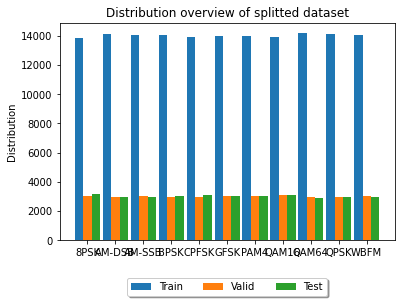

In [ ]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

## CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import regularizers

# Define the CNN architecture
cnn_in = keras.layers.Input(shape=(128, 2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu', kernel_initializer='he_uniform')(cnn)
cnn = keras.layers.BatchNormalization()(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.BatchNormalization()(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu', kernel_regularizer=regularizers.l2(0.01))(cnn)
cnn_out = keras.layers.Dense(len(mods), activation='softmax')(cnn)

# Create the model
model_cnn = keras.models.Model(inputs=cnn_in, outputs=cnn_out)

# Define optimizer and compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0007, clipnorm=1.0)
model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Define callbacks for learning rate adjustment and early stopping
callbacks = [
    keras.callbacks.ModelCheckpoint("cnn_model", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]


In [ ]:
# Clear any previous model from memory
tf.keras.backend.clear_session()

# Setup training parameters and model fitting
history = model_cnn.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=50,       # May adjust based on early stopping callback.
    verbose=2,       # Verbose=2 for one line per epoch, less verbose than default.
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks  # Include advanced callbacks for performance optimization.
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

callbacks.append(tensorboard_callback)


Epoch 1/50
1204/1204 - 18s - loss: 1.9349 - accuracy: 0.2750 - val_loss: 1.8653 - val_accuracy: 0.3060 - lr: 7.0000e-04 - 18s/epoch - 15ms/step
Epoch 2/50
1204/1204 - 5s - loss: 1.6625 - accuracy: 0.3747 - val_loss: 1.5733 - val_accuracy: 0.4184 - lr: 7.0000e-04 - 5s/epoch - 4ms/step
Epoch 3/50
1204/1204 - 6s - loss: 1.4673 - accuracy: 0.4448 - val_loss: 1.4793 - val_accuracy: 0.4365 - lr: 7.0000e-04 - 6s/epoch - 5ms/step
Epoch 4/50
1204/1204 - 6s - loss: 1.3830 - accuracy: 0.4716 - val_loss: 1.3691 - val_accuracy: 0.4862 - lr: 7.0000e-04 - 6s/epoch - 5ms/step
Epoch 5/50
1204/1204 - 5s - loss: 1.3356 - accuracy: 0.4862 - val_loss: 1.3655 - val_accuracy: 0.4790 - lr: 7.0000e-04 - 5s/epoch - 4ms/step
Epoch 6/50
1204/1204 - 5s - loss: 1.3097 - accuracy: 0.4951 - val_loss: 1.2990 - val_accuracy: 0.5064 - lr: 7.0000e-04 - 5s/epoch - 4ms/step
Epoch 7/50
1204/1204 - 5s - loss: 1.2945 - accuracy: 0.5004 - val_loss: 1.2915 - val_accuracy: 0.5102 - lr: 7.0000e-04 - 5s/epoch - 4ms/step
Epoch 8/50

In [ ]:
# Load the pre-trained model
model = keras.models.load_model("cnn_model")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)

# Print the test set results
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


1032/1032 [==============================] - 3s 3ms/step - loss: 1.1672 - accuracy: 0.5614
Test accuracy 0.5613636374473572
Test loss 1.1671860218048096



SNR -20dB:
50/50 - 0s - loss: 2.5273 - accuracy: 0.0914 - 367ms/epoch - 7ms/step

SNR -18dB:
52/52 - 0s - loss: 2.5444 - accuracy: 0.0728 - 236ms/epoch - 5ms/step

SNR -16dB:
53/53 - 0s - loss: 2.4697 - accuracy: 0.0954 - 246ms/epoch - 5ms/step

SNR -14dB:
54/54 - 0s - loss: 2.3730 - accuracy: 0.1125 - 248ms/epoch - 5ms/step

SNR -12dB:
50/50 - 0s - loss: 2.2324 - accuracy: 0.1481 - 159ms/epoch - 3ms/step

SNR -10dB:
53/53 - 0s - loss: 2.0411 - accuracy: 0.1988 - 158ms/epoch - 3ms/step

SNR -8dB:
52/52 - 0s - loss: 1.7547 - accuracy: 0.3215 - 201ms/epoch - 4ms/step

SNR -6dB:
52/52 - 0s - loss: 1.3684 - accuracy: 0.5024 - 222ms/epoch - 4ms/step

SNR -4dB:
53/53 - 0s - loss: 0.9970 - accuracy: 0.6359 - 154ms/epoch - 3ms/step

SNR -2dB:
52/52 - 0s - loss: 0.7085 - accuracy: 0.7320 - 241ms/epoch - 5ms/step

SNR 0dB:
52/52 - 0s - loss: 0.5234 - accuracy: 0.7910 - 224ms/epoch - 4ms/step

SNR 2dB:
51/51 - 0s - loss: 0.4692 - accuracy: 0.8300 - 162ms/epoch - 3ms/step

SNR 4dB:
52/52 - 0s - l

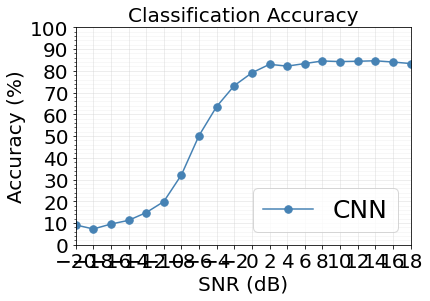

array([0.09136736, 0.07277138, 0.09537914, 0.11246376, 0.14812499,
       0.19880952, 0.32153752, 0.50242424, 0.63593102, 0.73204589,
       0.79098111, 0.83003706, 0.82166767, 0.83353806, 0.8454318 ,
       0.84264266, 0.84409255, 0.84629297, 0.84056199, 0.8336252 ])

In [ ]:
SNR_accuracy(SNR, 'CNN')

# Plot Confusion Matrix

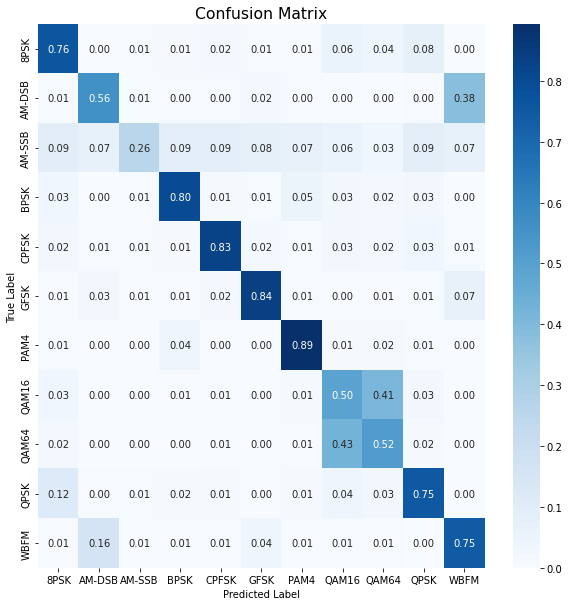

In [ ]:
All_SNR_show_confusion_matrix([X_test], save=False)

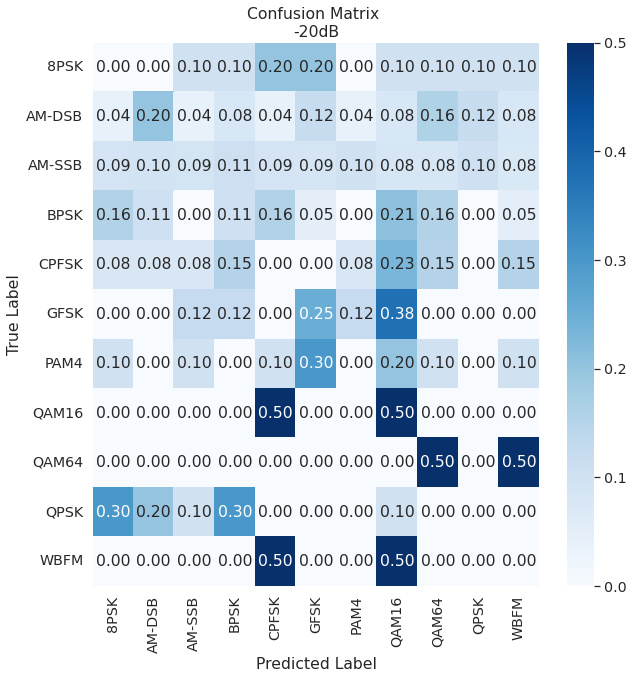

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


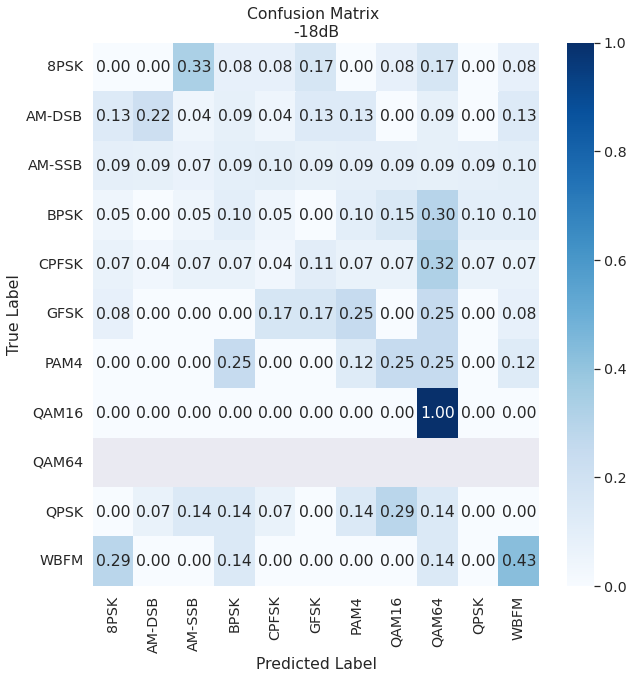

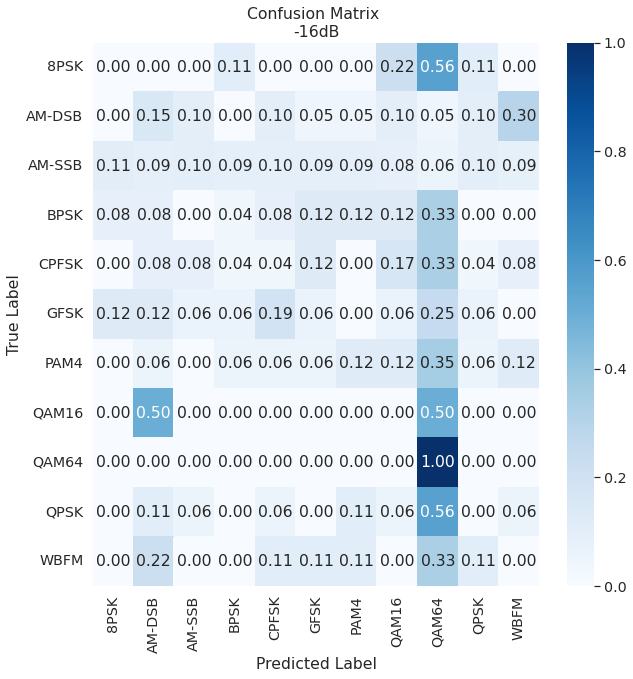

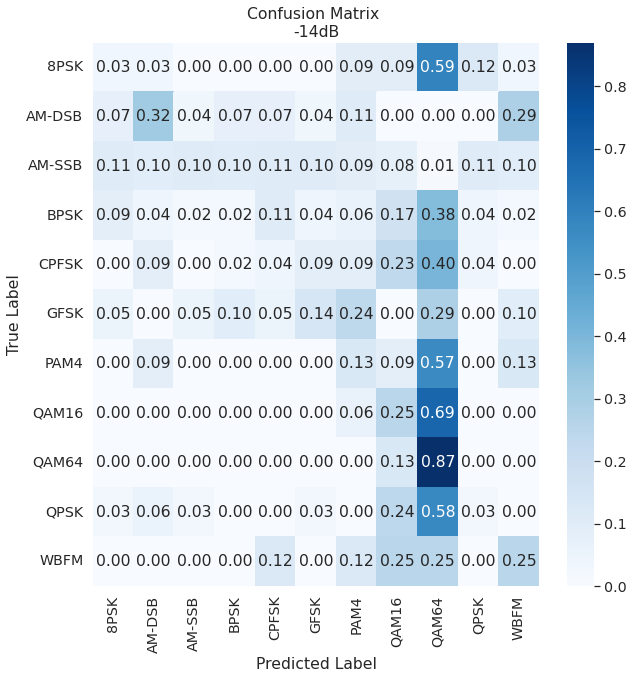

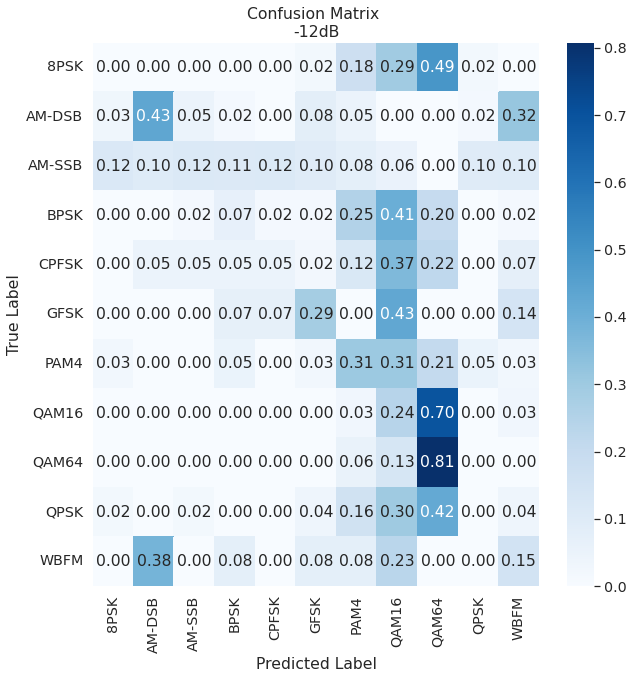

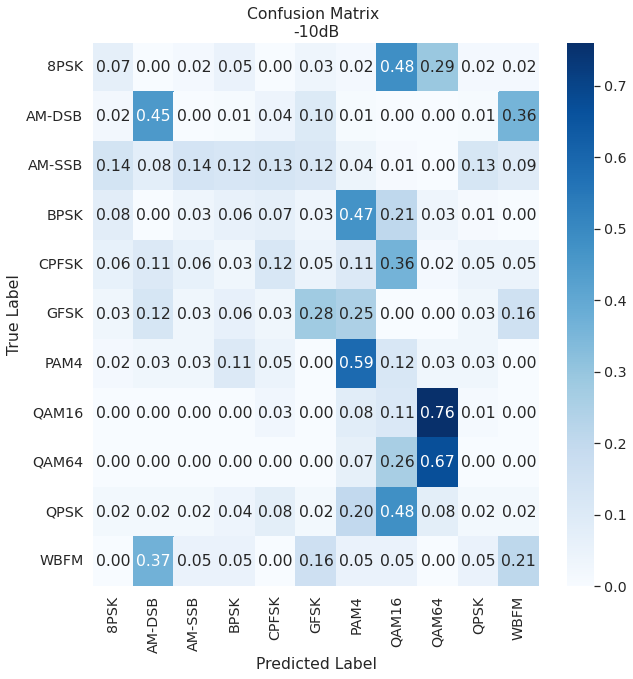

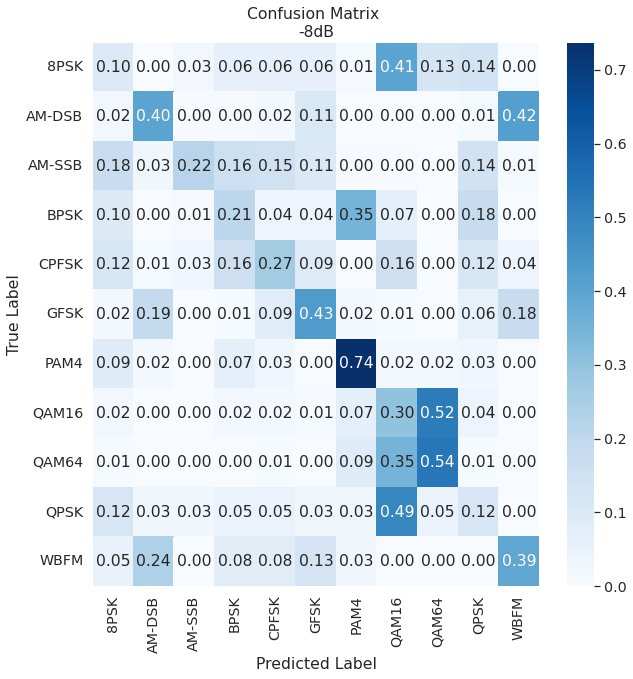

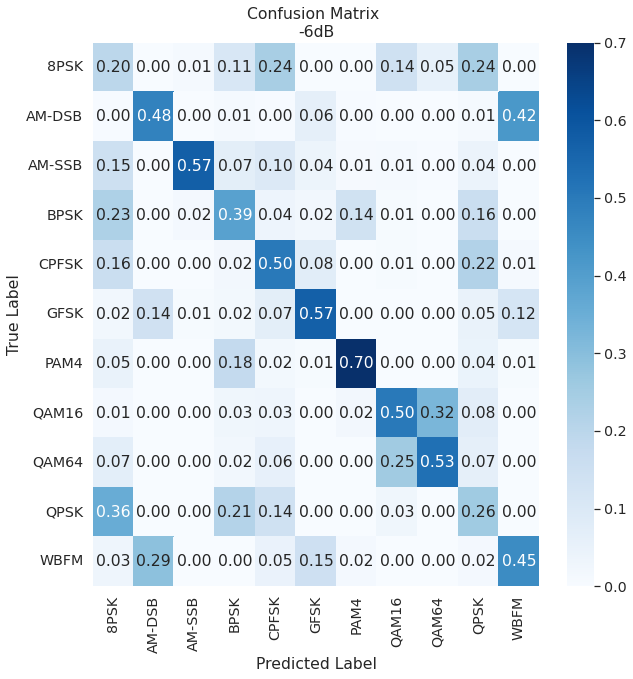

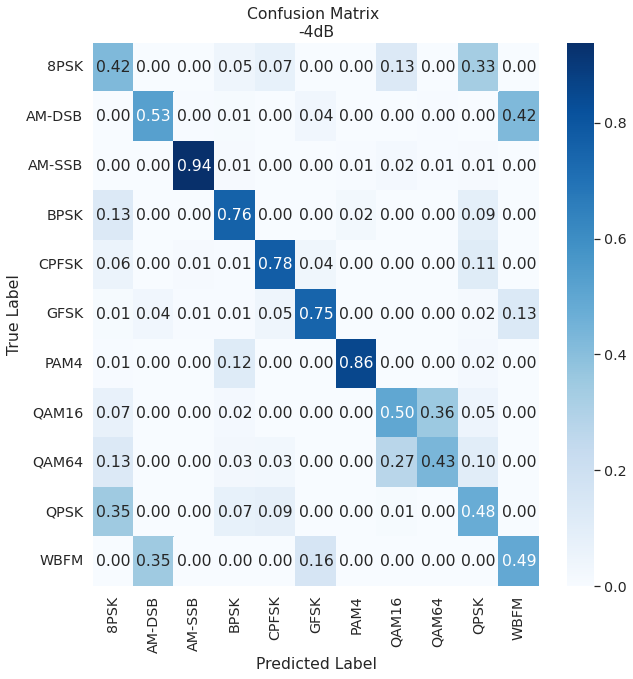

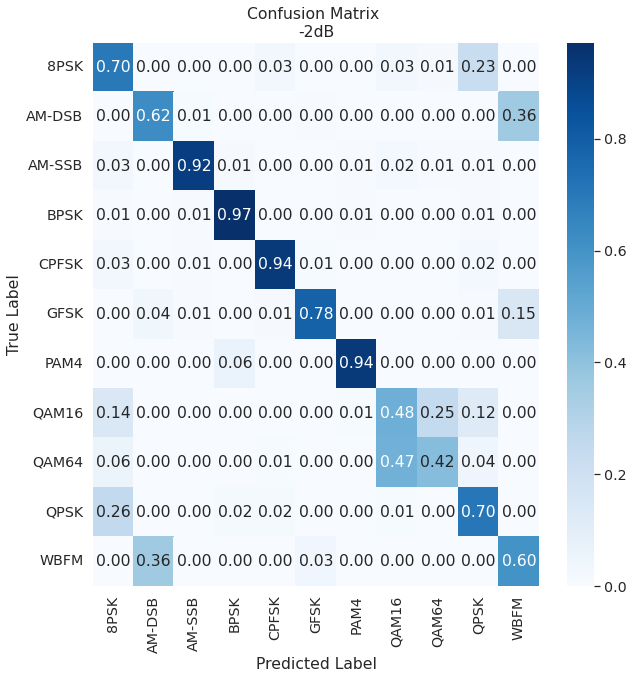

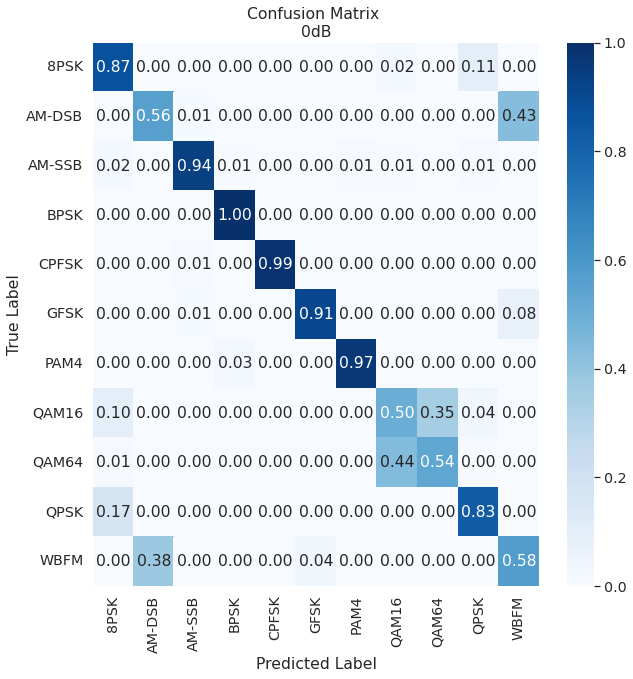

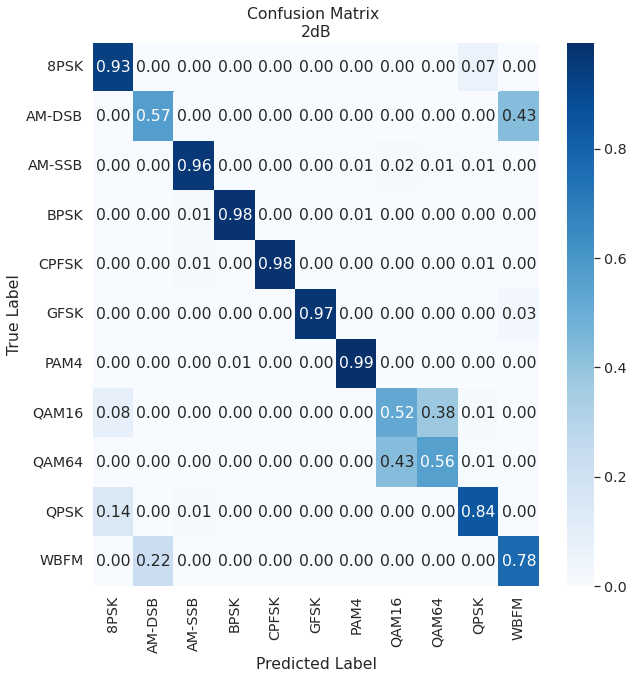

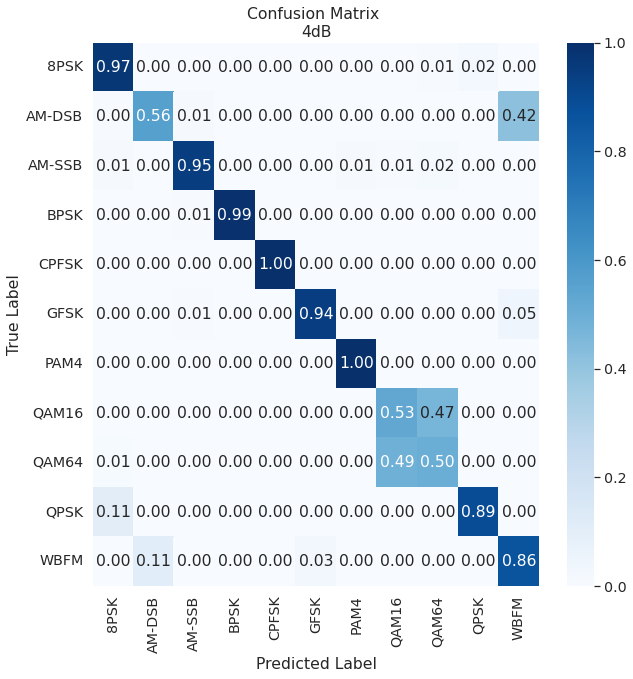

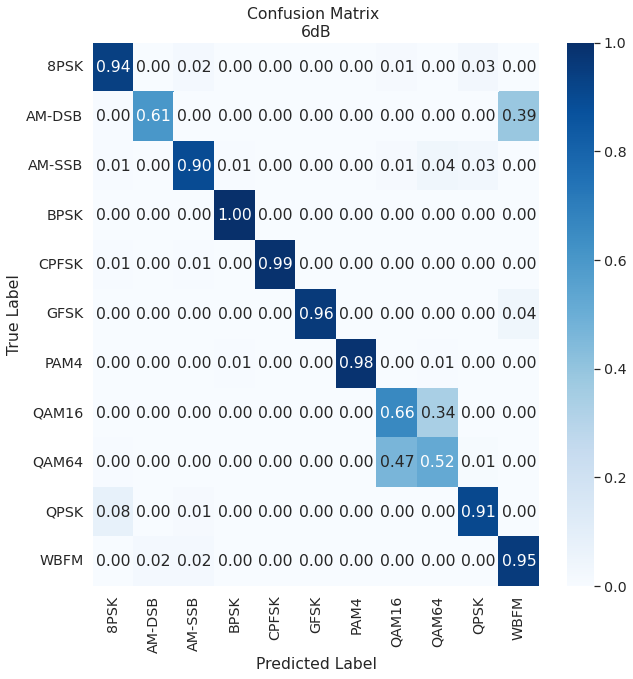

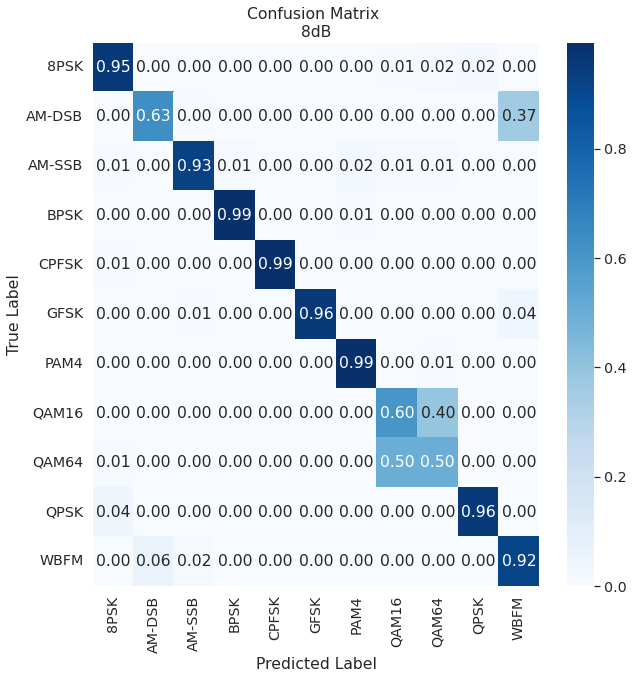

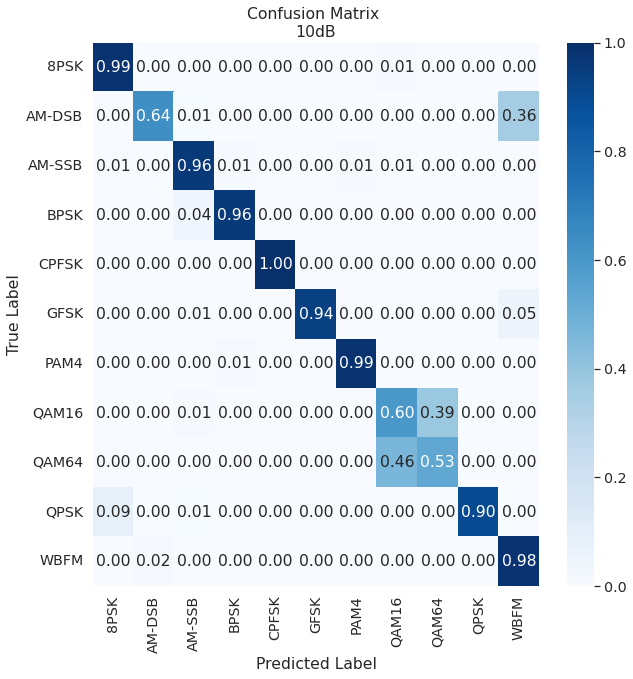

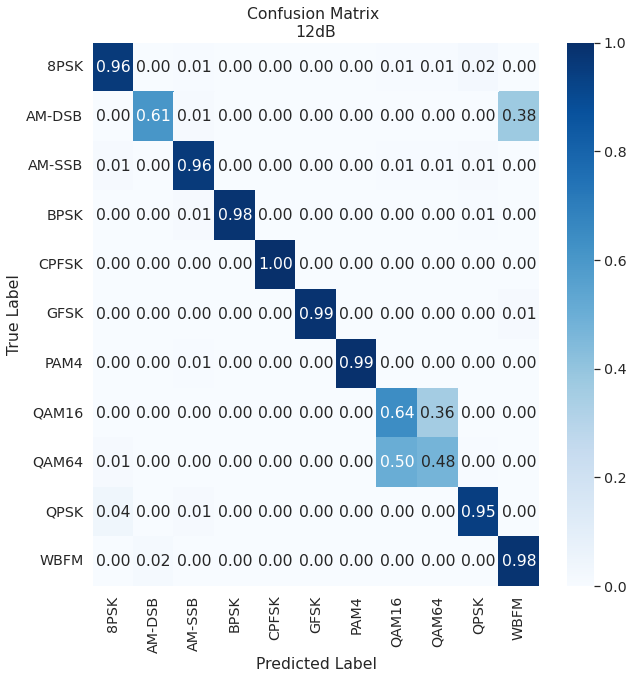

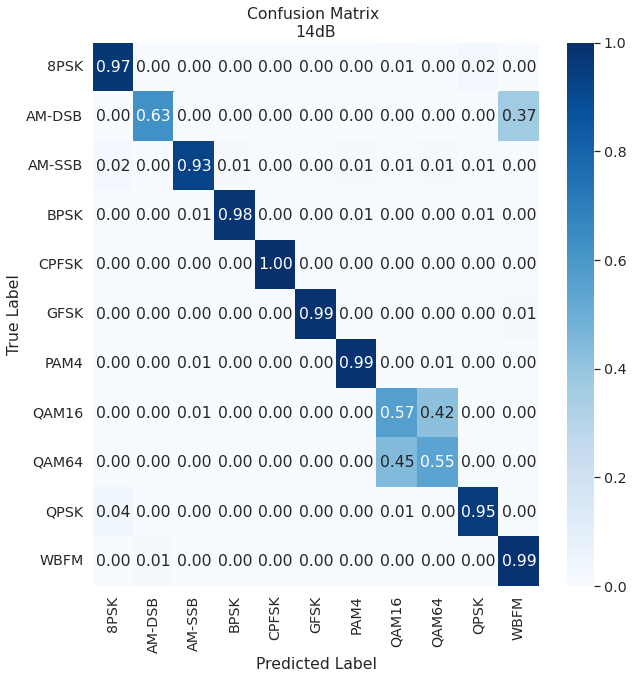

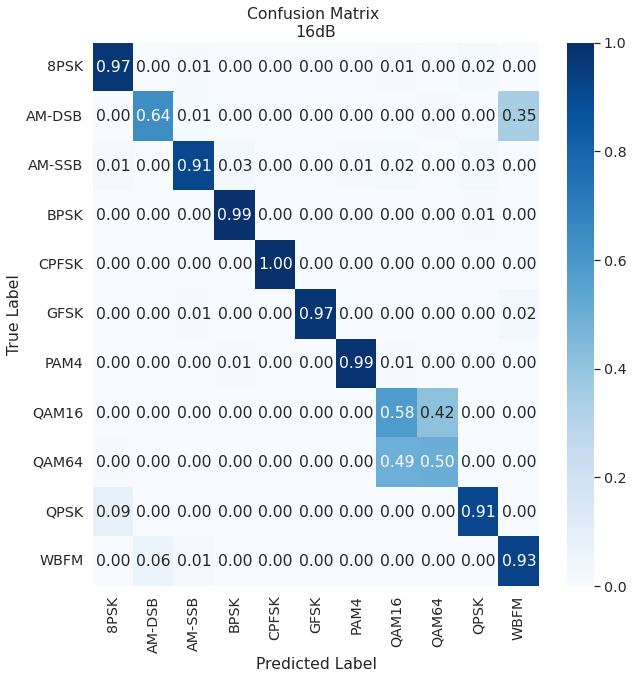

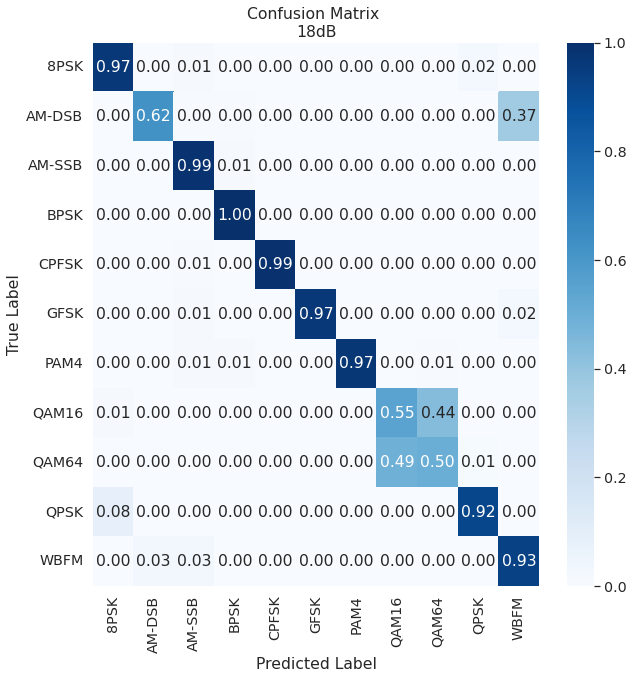

In [ ]:
SNR_show_confusion_matrix(SNR, lbl_SNR[:], X_test, save=False)